# Classical pipeline

In [1]:
from discopy.tensor import Tensor
import tensornetwork as tn
import torch

np = Tensor.np = torch
tn.set_default_backend('pytorch')
torch.array = torch.as_tensor
torch.cuda.set_device(0)
torch.manual_seed(0)
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

### Input data

In [2]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append(int(line[0]))
            sentences.append(line[1:].strip())
    return torch.as_tensor(labels, dtype=torch.float32), sentences


train_labels, train_data = read_data('datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('datasets/mc_dev_data.txt')
test_labels, test_data = read_data('datasets/mc_test_data.txt')

### Create diagrams

In [3]:
from lambeq.ccg2discocat import DepCCGParser

reader = DepCCGParser(possible_root_cats=['S[dcl]'])

train_diagrams = reader.sentences2diagrams(train_data)
dev_diagrams = reader.sentences2diagrams(dev_data)
test_diagrams = reader.sentences2diagrams(test_data)

### Create circuits

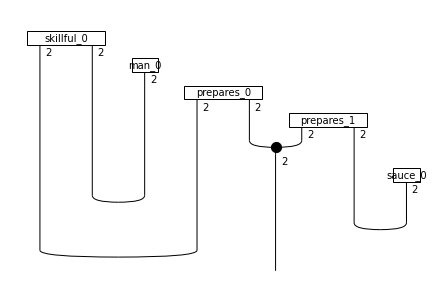

In [4]:
from discopy import Dim

from lambeq.tensor import SpiderAnsatz
from lambeq.core.types import AtomicType

ansatz = SpiderAnsatz({AtomicType.NOUN: Dim(2),
                       AtomicType.SENTENCE: Dim(2)})

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw()

### Parameterise

In [5]:
from sympy import default_sort_key

all_circuits = train_circuits + dev_circuits + test_circuits

# sort the symbols since they are returned as a set
parameters = sorted(
    {s for circ in all_circuits for s in circ.free_symbols},
    key=default_sort_key)

In [6]:
def make_pred_fn(circuits):
    def predict(params):
        return torch.stack(
            [c.lambdify(*parameters)(*params).eval(contractor=tn.contractors.auto).array
             for c in circuits])
    return predict


train_pred_fn = make_pred_fn(train_circuits)
dev_pred_fn = make_pred_fn(dev_circuits)
test_pred_fn = make_pred_fn(test_circuits)

### Train

In [7]:
def train(func, x0, niter, callback, optimizer_fn, lr):
    x = [t.detach().requires_grad_() for t in x0]
    optimizer = optimizer_fn(x, lr=lr)
    for _ in range(niter):
        loss = func(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            callback(x)
    return x


def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)
        
        logits = predictions[:, 1] - predictions[:, 0]

        loss_fn = torch.nn.BCEWithLogitsLoss()
        cost = loss_fn(logits, labels)
        costs.append(cost.item())
        
        with torch.no_grad():
            acc = np.sum((logits > 0) == labels) / len(labels)
            accuracies.append(acc.item())
            
        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies


x0 = [torch.nn.init.uniform_(torch.empty(p.size)) for p in parameters]

train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, dev_labels)

result = train(train_cost_fn, x0, niter=20, callback=dev_cost_fn,
               optimizer_fn=torch.optim.AdamW, lr=0.1)

### Show results

Test accuracy: 1.0


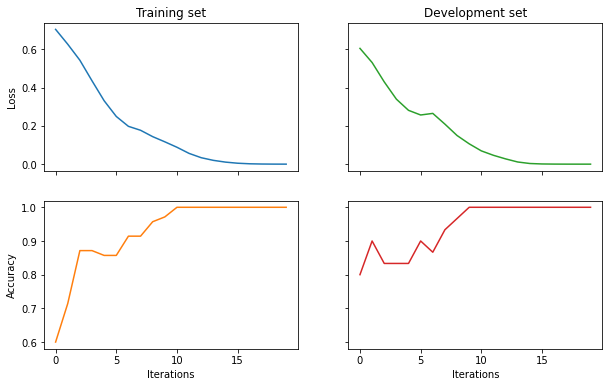

In [8]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(train_costs, color=next(colours))
ax_bl.plot(train_accs, color=next(colours))
ax_tr.plot(dev_costs, color=next(colours))
ax_br.plot(dev_accs, color=next(colours))

# print test accuracy
test_cost_fn, _, test_accs = make_cost_fn(test_pred_fn, test_labels)
test_cost_fn(result)
print('Test accuracy:', test_accs[0])